In [154]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

In [155]:
import os
import numpy as np
import torch
import proplot as pplt
import matplotlib.pyplot as plt
import torch.nn.functional as F
from mpl_toolkits.basemap import Basemap
import baselines
import utils

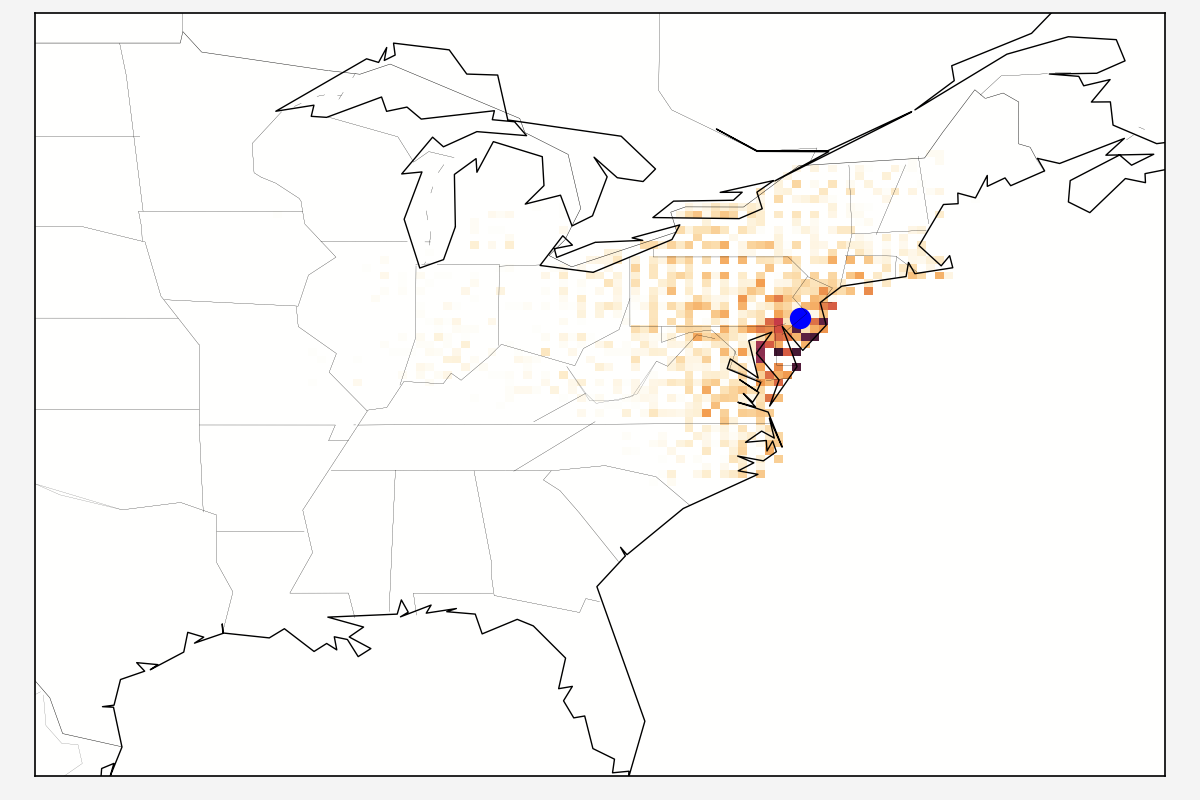

In [161]:
dev = "cuda" if torch.cuda.is_available() else "cpu"
pi, pj = 48, 205
ext = [-135.0, 20.0, -60.0, 52.0]
lon = ext[0] + (pj / 256) * (ext[2] - ext[0])
lat = ext[3] - (pi / 128) * (ext[3] - ext[1])
grads = []
b = 3
smt = 1
fig, axs = pplt.subplots([1], figsize=(6, 4))
ax = axs[0]

for sim in range(1):
    C, A, Y, M, Mtrain, Mtest = utils.load_medicare_data("../data/medicare", sim)
    C, A, Y = [torch.FloatTensor(u[None]).to(dev) for u in (C, A, Y)]
    nd, nr, nc = C.shape[1:]
    Ctrain, Ctest = C, C
    Atrain, Atest = A, A
    Ytrain, Ytest = Y, Y
    Mtrain, Mtest, M = [torch.FloatTensor(u).to(dev) for u in (Mtrain, Mtest, M)]

    ckptdir = f"../results/medicare/sim{sim:03d}/checkpoints/"
    ckpt = f"{ckptdir}/{sorted(os.listdir(ckptdir))[-1]}"
    model = baselines.UNetCausalPosRegression.load_from_checkpoint(ckpt).to(dev)

    C.requires_grad_(True)
    g = torch.zeros_like(Y)
    g[..., (pi-b):(pi+b+1), (pj-b):(pj+b+1)] = 1
    out = model(C, A)
    out.backward(gradient=g)
    grad = C.grad
    K = torch.ones((1, 1, smt, smt), device=dev)
    grad = torch.cat(
        [F.conv2d(grad[0, j].view(1, 1, nr, nc), K, padding='same') for j in range(nd)],
        axis=1
    )
    grad = grad.norm(1, dim=1)
    l, u = grad[M > 0].amin(), grad[M > 0].amax()
    grad = (grad - l) / (u - l)
    grads.append(grad * M[0])

grads = torch.cat(grads).mean(0).cpu().numpy()
m = Basemap(projection="cyl", *ext, ax=ax)
m.drawcoastlines(0.5)
m.drawstates(0.05)
m.drawcountries(0.15)
ax.set_xlim(-100.0, -63.0)
ax.set_ylim(25.0, 50.0)
ax.scatter(lon, lat, c="blue", m=".", s=200)
m.imshow(grads[::-1], vmin=0.025, vmax=1.0)

plt.savefig("../figures/rf_outcome.png", bbox_inches="tight")

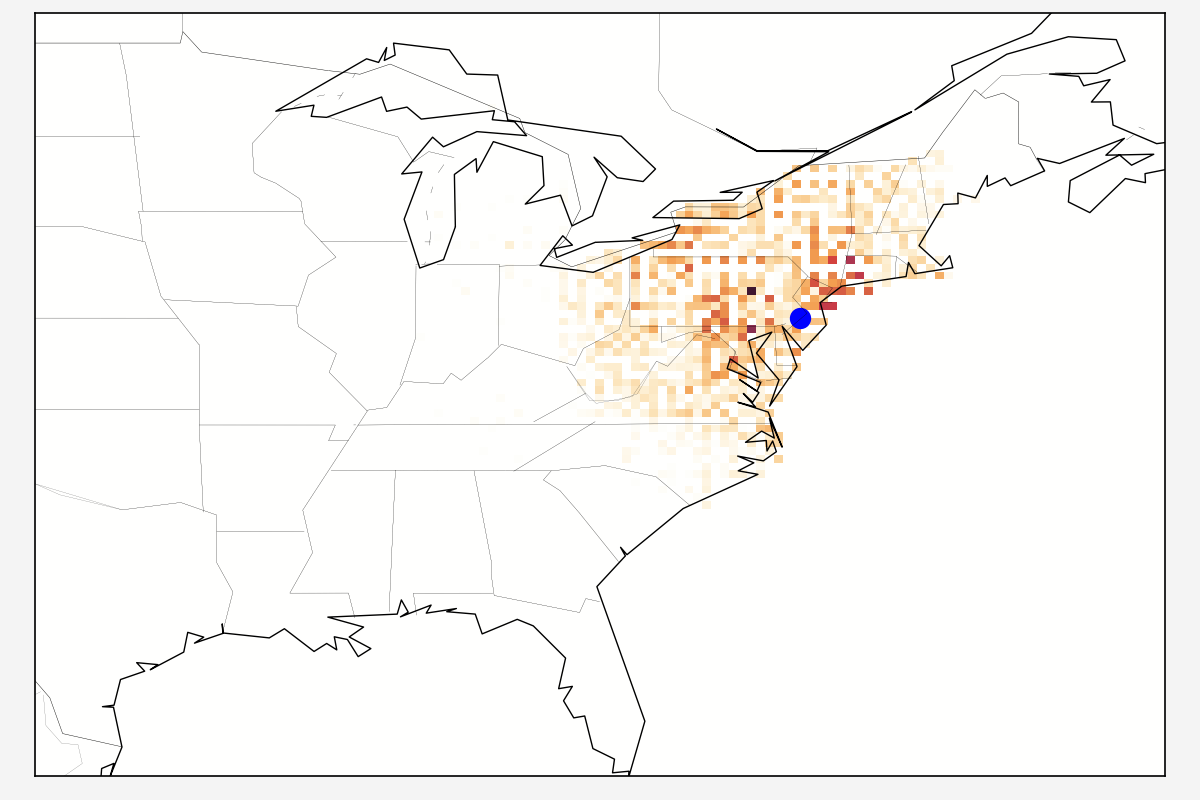

In [162]:
dev = "cuda" if torch.cuda.is_available() else "cpu"
pi, pj = 48, 205
ext = [-135.0, 20.0, -60.0, 52.0]
lon = ext[0] + (pj / 256) * (ext[2] - ext[0])
lat = ext[3] - (pi / 128) * (ext[3] - ext[1])
grads = []
b = 3
fig, axs = pplt.subplots([1], figsize=(6, 4))
ax = axs[0]

for sim in range(1):
    C, A, Y, M, Mtrain, Mtest = utils.load_medicare_data("../data/medicare", sim)
    C, A, Y = [torch.FloatTensor(u[None]).to(dev) for u in (C, A, Y)]
    nd, nr, nc = C.shape[1:]
    Ctrain, Ctest = C, C
    Atrain, Atest = A, A
    Ytrain, Ytest = Y, Y
    Mtrain, Mtest, M = [torch.FloatTensor(u).to(dev) for u in (Mtrain, Mtest, M)]

    ckptdir = f"../results/medicare/sim{sim:03d}/checkpoints/"
    ckpt = f"{ckptdir}/{sorted(os.listdir(ckptdir))[-1]}"
    model = baselines.UNetCausalPosRegression.load_from_checkpoint(ckpt).to(dev)

    C.requires_grad_(True)
    g = torch.zeros_like(Y)
    g[..., (pi-b):(pi+b+1), (pj-b):(pj+b+1)] = 1
    out = model.g(model.unet(C))
    out.backward(gradient=g)
    grad = C.grad
    K = torch.ones((1, 1, smt, smt), device=dev)
    grad = torch.cat(
        [F.conv2d(grad[0, j].view(1, 1, nr, nc), K, padding='same') for j in range(nd)],
        axis=1
    )
    grad = grad.norm(1, dim=1)
    l, u = grad[M > 0].amin(), grad[M > 0].amax()
    grad = (grad - l) / (u - l)
    grads.append(grad * M[0])

grads = torch.cat(grads).mean(0).cpu().numpy()
m = Basemap(projection="cyl", *ext, ax=ax)
m.drawcoastlines(0.5)
m.drawstates(0.05)
m.drawcountries(0.15)
ax.set_xlim(-100.0, -63.0)
ax.set_ylim(25.0, 50.0)
ax.scatter(lon, lat, c="blue", m=".", s=200)
m.imshow(grads[::-1], vmin=0.025, vmax=1.0)

plt.savefig("../figures/rf_treatment.png", bbox_inches="tight")